In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from keras.applications import InceptionV3
from keras.models import Model
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from keras.applications import ResNet50
from keras.applications import EfficientNetB0

# Loading Data and Preprocessing Data

In [6]:
def load_and_preprocess_data(directory, img_size=150, test_size=None, random_state=None):
    data = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        class_num = 1 if label == 'NORMAL' else 0  
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            try:
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    images = np.array([item[0] for item in data]) / 255.0
    labels = np.array([item[1] for item in data])

    if test_size:
        x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state)
        return x_train, y_train, x_test, y_test

    return images, labels

In [7]:
# Load and preprocess train data
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# Train Data

In [8]:
train_dir = os.path.join(data_dir,'train')
x_train, y_train, x_val, y_val = load_and_preprocess_data(train_dir, test_size=0.2, random_state=42)
x_train = x_train.reshape(-1, 150, 150, 1)

In [13]:
len(x_train),len(y_train)

(4172, 4172)

In [14]:
def display_images_horizontally(image_paths, class_names, target_size=(256, 256)):
    num_images = len(image_paths)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

    for i, (image_path, class_name) in enumerate(zip(image_paths, class_names)):
        # Load and resize the image to the target size
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, target_size)
        # Display the image
        axs[i].imshow(image)
        axs[i].set_title(f'Class: {class_name}')
        axs[i].axis('off')
    plt.show()

In [17]:
# Define paths to the images
image_paths = [
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1003_virus_1685.jpeg',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0168-0001.jpeg',
]

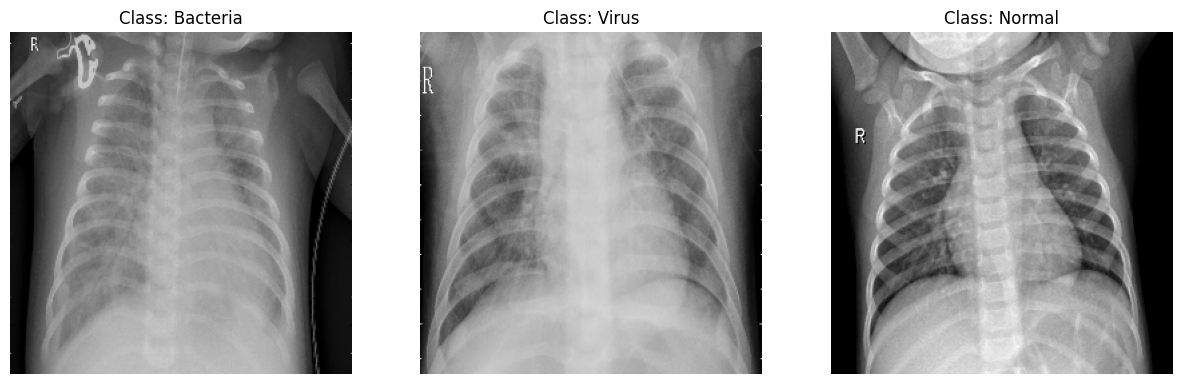

In [18]:
# Define corresponding class names
class_names = ['Bacteria', 'Virus', 'Normal']

# Display images horizontally with the same size
display_images_horizontally(image_paths, class_names)

# Validation Data

In [19]:
# Load and preprocess validation data
val_dir = os.path.join(data_dir, 'val')
x_val, y_val = load_and_preprocess_data(val_dir)
x_val = x_val.reshape(-1, 150, 150, 1)

In [20]:
len(x_val),len(y_val)

(16, 16)

# Test Data

In [21]:
# Load and preprocess test data
test_dir = os.path.join(data_dir, 'test')
x_test, y_test = load_and_preprocess_data(test_dir)
x_test = x_test.reshape(-1, 150, 150, 1)

In [22]:
len(x_test),len(y_test)

(624, 624)

In [23]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(x_train)

# Model-1 Architecture(CNN)

In [24]:
def create_model(optimizer='rmsprop', dropout_rate=0.2, units=120):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [25]:
model = create_model(optimizer='rmsprop', dropout_rate=0.2, units=120)

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [27]:
from warnings import filterwarnings
filterwarnings('ignore')
# Model training
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=datagen.flow(x_val, y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/10


2023-12-05 17:00:15.671326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 22s 67ms/step - loss: 0.6592 - accuracy: 0.8121 - val_loss: 35.6911 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 9s 65ms/step - loss: 0.3240 - accuracy: 0.8607 - val_loss: 50.2647 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9046
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 8s 62ms/step - loss: 0.2494 - accuracy: 0.9046 - val_loss: 62.1661 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 8s 61ms/step - loss: 0.1713 - accuracy: 0.9408 - val_loss: 45.4371 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
131/131 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9420
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
131/131 [==============================] - 8s

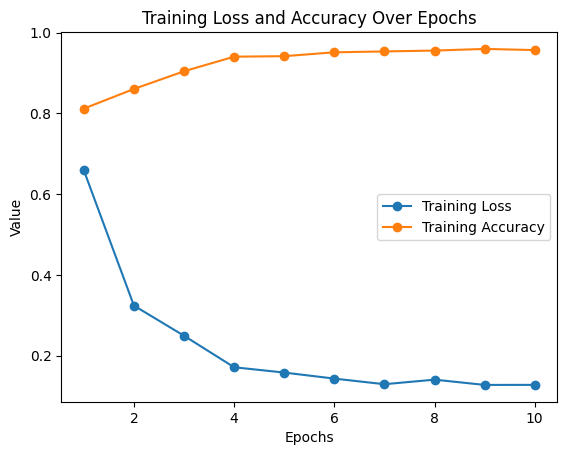

In [28]:
# Access training loss and accuracy values
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']  # Replace 'accuracy' with the actual key used in your model training
# Plotting the training loss
plt.plot(range(1, len(training_loss) + 1), training_loss, marker='o', label='Training Loss')
# Plotting the training accuracy
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, marker='o', label='Training Accuracy')
# Set labels and title
plt.title('Training Loss and Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
# Display the plot
plt.show()

In [29]:
# Model evaluation on the validation data
test_loss, test_accuracy = model.evaluate(x_val, y_val)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

1/1 [==============================] - 0s 35ms/step - loss: 0.4994 - accuracy: 0.8125
Test Loss: 0.49941885471343994, Test Accuracy: 81.25%


In [30]:
#Model evaluation on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

20/20 [==============================] - 0s 11ms/step - loss: 0.2943 - accuracy: 0.8910
Test Loss: 0.2942526638507843, Test Accuracy: 89.10256624221802%


In [41]:
threshold = 0.5
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

20/20 [==============================] - 0s 10ms/step
Accuracy: 0.8910
Precision: 0.8320
Recall: 0.8889
F1 Score: 0.8595


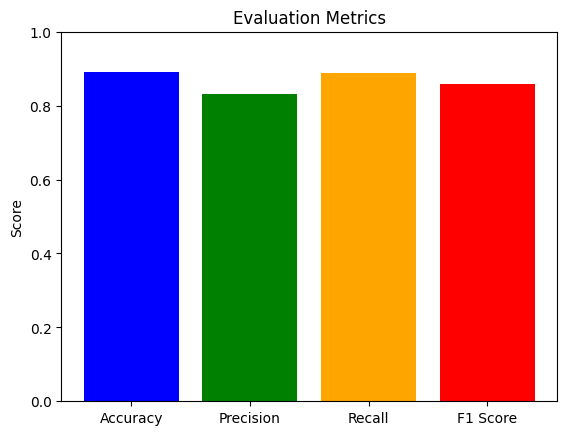

In [46]:
metrics = {
    'Accuracy': 0.8910,
    'Precision': 0.8320,
    'Recall': 0.8889,
    'F1 Score': 0.8595
}
# Plotting the metrics
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim([0, 1])  # Setting y-axis limit to match score range (0 to 1)
plt.show()

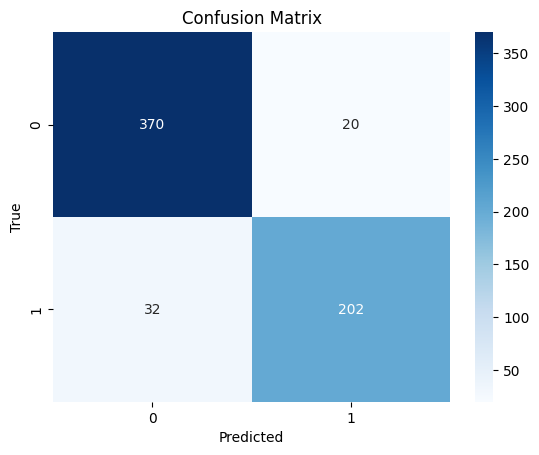

In [26]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
model.save('Model.keras')

In [31]:
# Save the entire model
model.save('Model.h5')

# Load the entire model
from keras.models import load_model
model = load_model('Model.h5')

# HyperParameter Tuning

In [27]:
param_grid = {
    'optimizer': ['rmsprop',],
    'dropout_rate': [0.1,0.2],
    'units': [64,120]
}

In [28]:
# Initialize lists to store results
grid_results = []
best_score = 0
best_params = None

In [30]:
# Perform grid search
for optimizer in param_grid['optimizer']:
    for dropout_rate in param_grid['dropout_rate']:
        for units in param_grid['units']:
            # Create model with current hyperparameters
            model = create_model(optimizer=optimizer, dropout_rate=dropout_rate, units=units)
            # Train the model
            history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])
            # Evaluate the model on validation set
            val_loss, val_acc = model.evaluate(x_val, y_val)
            # Save results
            grid_results.append({
                'optimizer': optimizer,
                'dropout_rate': dropout_rate,
                'units': units,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'history': history
            })
            # Update best score and parameters
            if val_acc > best_score:
                best_score = val_acc
                best_params = {'optimizer': optimizer, 'dropout_rate': dropout_rate, 'units': units}

Epoch 1/10


2023-12-03 11:37:52.779346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 10s 51ms/step - loss: 0.4163 - accuracy: 0.8876 - val_loss: 23.9261 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 6s 49ms/step - loss: 0.1333 - accuracy: 0.9513 - val_loss: 102.7661 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
130/131 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9649
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 6s 49ms/step - loss: 0.0978 - accuracy: 0.9650 - val_loss: 44.9354 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 6s 49ms/step - loss: 0.0409 - accuracy: 0.9849 - val_loss: 27.3714 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
130/131 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.9913
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
131/131 [==============================] - 6

2023-12-03 11:39:01.875307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 10s 52ms/step - loss: 0.4808 - accuracy: 0.8809 - val_loss: 37.6905 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 7s 50ms/step - loss: 0.1277 - accuracy: 0.9569 - val_loss: 34.1131 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
130/131 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9668
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 7s 51ms/step - loss: 0.0937 - accuracy: 0.9664 - val_loss: 30.0980 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 7s 51ms/step - loss: 0.0345 - accuracy: 0.9863 - val_loss: 19.0143 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
131/131 [==============================] - 7s 51ms/step - loss: 0.0213 - accuracy: 0.9923 - val_loss: 5.2037 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/10
131/131 [==============================] - 7s 

2023-12-03 11:40:12.945722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 10s 52ms/step - loss: 0.4874 - accuracy: 0.8790 - val_loss: 8.9110 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 7s 51ms/step - loss: 0.1503 - accuracy: 0.9461 - val_loss: 29.8230 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
130/131 [============================>.] - ETA: 0s - loss: 0.1077 - accuracy: 0.9642
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 7s 51ms/step - loss: 0.1075 - accuracy: 0.9643 - val_loss: 20.6096 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 7s 51ms/step - loss: 0.0496 - accuracy: 0.9832 - val_loss: 14.0587 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
131/131 [==============================] - 7s 51ms/step - loss: 0.0367 - accuracy: 0.9861 - val_loss: 1.6694 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/10
131/131 [==============================] - 7s 5

2023-12-03 11:41:24.480137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 10s 52ms/step - loss: 0.5696 - accuracy: 0.8802 - val_loss: 7.7859 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 6s 50ms/step - loss: 0.1505 - accuracy: 0.9492 - val_loss: 9.1570 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
130/131 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9647
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 7s 50ms/step - loss: 0.1171 - accuracy: 0.9648 - val_loss: 10.5261 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 7s 51ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 7.0009 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
131/131 [==============================] - 7s 51ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 4.9104 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/10
131/131 [==============================] - 7s 51m

In [31]:
# Print the best parameters and results
print("Best score: {:.4f}".format(best_score))
print("Best parameters:", best_params)

Best score: 1.0000
Best parameters: {'optimizer': 'rmsprop', 'dropout_rate': 0.1, 'units': 120}


In [32]:
# Assume best_params contains the best hyperparameters from grid search
best_optimizer = best_params['optimizer']
best_dropout_rate = best_params['dropout_rate']
best_units = best_params['units']

# Create the final model with the best hyperparameters
final_model = create_model(optimizer=best_optimizer, dropout_rate=best_dropout_rate, units=best_units)

# Train the final model on the entire training set
final_model.fit(x_train, y_train, epochs=10, batch_size=32)

# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(x_test, y_test)

Epoch 1/10


2023-12-03 11:43:05.561105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 9s 48ms/step - loss: 0.4081 - accuracy: 0.8919
Epoch 2/10
131/131 [==============================] - 6s 49ms/step - loss: 0.1364 - accuracy: 0.9578
Epoch 3/10
131/131 [==============================] - 6s 49ms/step - loss: 0.0922 - accuracy: 0.9698
Epoch 4/10
131/131 [==============================] - 6s 49ms/step - loss: 0.0780 - accuracy: 0.9765
Epoch 5/10
131/131 [==============================] - 7s 50ms/step - loss: 0.0569 - accuracy: 0.9777
Epoch 6/10
131/131 [==============================] - 6s 49ms/step - loss: 0.0416 - accuracy: 0.9871
Epoch 7/10
131/131 [==============================] - 7s 50ms/step - loss: 0.0333 - accuracy: 0.9899
Epoch 8/10
131/131 [==============================] - 6s 49ms/step - loss: 0.0353 - accuracy: 0.9897
Epoch 9/10
131/131 [==============================] - 7s 50ms/step - loss: 0.0265 - accuracy: 0.9933
Epoch 10/10
20/20 [==============================] - 0s 10ms/step - loss: 4.2140 - accuracy: 0.7388


In [34]:
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Test Loss: {:.4f}".format(test_loss))


Test Accuracy: 0.7388
Test Loss: 4.2140


# Model-2: SVM

In [35]:
# Flatten the images for SVM
x_train_flat = x_train.reshape(len(x_train), -1)
x_val_flat = x_val.reshape(len(x_val), -1)
x_test_flat = x_test.reshape(len(x_test), -1)

# Standardize the data
scaler = StandardScaler()
x_train_flat_scaled = scaler.fit_transform(x_train_flat)
x_val_flat_scaled = scaler.transform(x_val_flat)
x_test_flat_scaled = scaler.transform(x_test_flat)

# Create an SVM model
svm_model = svm.SVC()

In [36]:
# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [38]:
# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(svm_model, param_grid, cv=3)
grid_search.fit(x_train_flat_scaled, y_train)

# Print the best parameters found by grid search
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [47]:
# Get the best parameters from grid search
best_params = grid_search.best_params_

# Create an SVM model with the best parameters
best_svm_model = svm.SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])

# Train the model on the training data
best_svm_model.fit(x_train_flat_scaled, y_train)

# Predict the labels for the test set
y_pred = best_svm_model.predict(x_test_flat_scaled)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the evaluation results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 0.7628205128205128

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.99      0.84       390
           1       0.95      0.39      0.55       234

    accuracy                           0.76       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.76      0.73       624



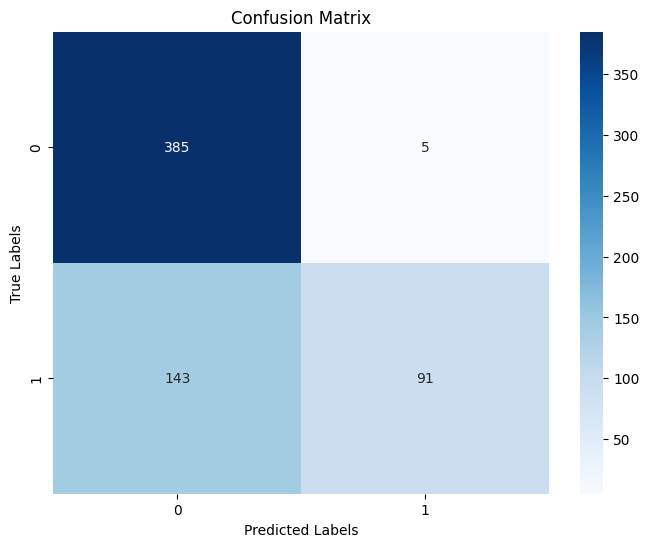

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Model-3 Resnet 50

In [100]:
# Create a ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))  # Assumes RGB images
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(Conv2D(3, (3, 3), padding='same', input_shape=(150, 150, 1)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=datagen.flow(x_val, y_val),
                    callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                 patience=2,
                                                 verbose=1,
                                                 factor=0.3,
                                                 min_lr=0.000001)])

Epoch 1/10
131/131 [==============================] - 28s 164ms/step - loss: 0.5868 - accuracy: 0.7488 - val_loss: 0.7237 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 18s 138ms/step - loss: 0.4147 - accuracy: 0.7948 - val_loss: 0.6828 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 18s 136ms/step - loss: 0.3857 - accuracy: 0.8020 - val_loss: 0.7279 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 18s 137ms/step - loss: 0.3404 - accuracy: 0.8432 - val_loss: 0.7230 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 18s 138ms/step - loss: 0.3681 - accuracy: 0.8279 - val_loss: 0.4602 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - 18s 138ms/step - loss: 0.3566 - accuracy: 0.8408 - val_loss: 0.9321 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/10
131/131 [==============================] 

In [101]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

20/20 [==============================] - 1s 56ms/step - loss: 0.3793 - accuracy: 0.8542
Test Accuracy: 85.42%


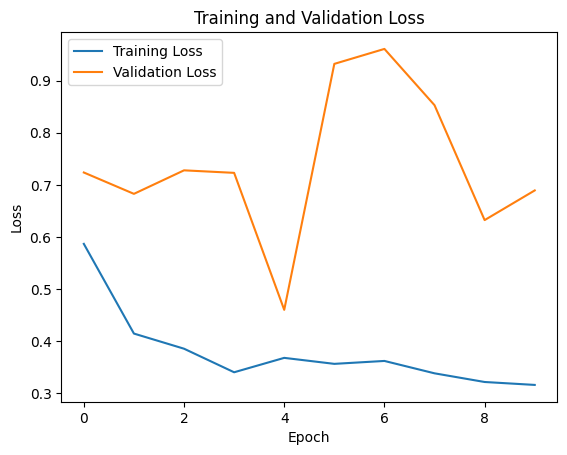

In [102]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model-4  Inception V3

In [2]:
# Load and preprocess test data
test_dir = os.path.join(data_dir, 'test')
x_test, y_test, _, _ = load_and_preprocess_data(test_dir, test_size=0.2, random_state=42)
x_test = x_test.reshape(-1, 150, 150, 3)


In [6]:

def create_inception_model(units=120, dropout_rate=0.2):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model = Sequential()
    model.add(BatchNormalization(input_shape=(150, 150, 3)))  # Update input shape to 3 channels
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create and compile the model
model = create_inception_model(units=120, dropout_rate=0.2)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)
# Model training
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=datagen.flow(x_val, y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/10
131/131 [==============================] - 71s 237ms/step - loss: 0.2752 - accuracy: 0.8921 - val_loss: 0.4808 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 26s 198ms/step - loss: 0.1743 - accuracy: 0.9382 - val_loss: 0.5049 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 26s 199ms/step - loss: 0.1440 - accuracy: 0.9463 - val_loss: 0.6338 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 26s 200ms/step - loss: 0.1379 - accuracy: 0.9540 - val_loss: 0.6318 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9564
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 26s 200ms/step - loss: 0.1233 - accuracy: 0.9564 - val_loss: 0.4830 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 6/10
131/131 [=============================

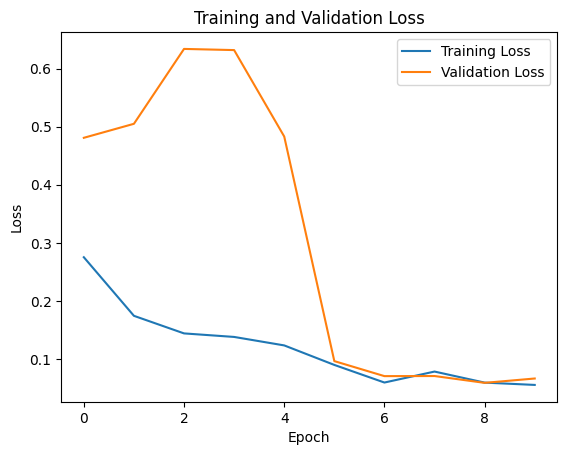

In [9]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

16/16 [==============================] - 2s 109ms/step - loss: 0.5037 - accuracy: 0.9279
Test Loss: 0.5037
Test Accuracy: 92.79%


# Models Comparison

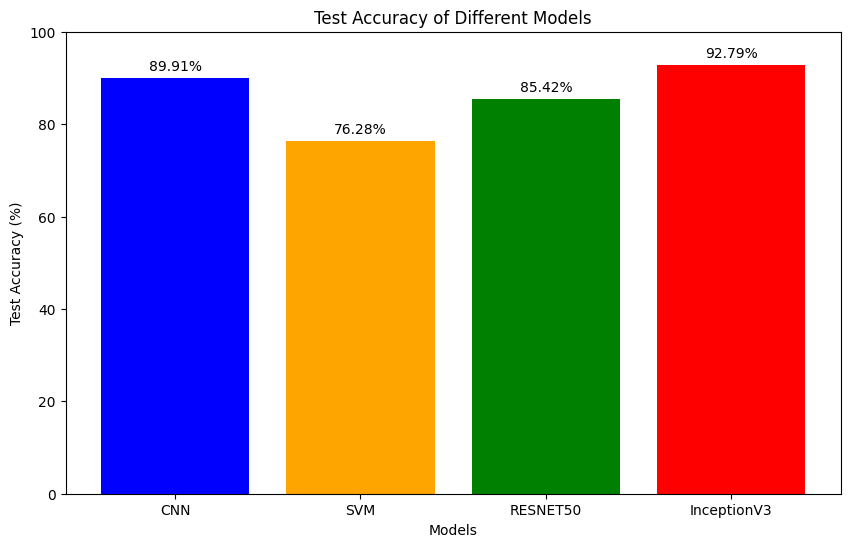

In [47]:
import matplotlib.pyplot as plt

models = ['CNN', 'SVM', 'RESNET50', 'InceptionV3']
accuracies = [89.91, 76.28, 85.42, 92.79]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Test Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')

# Adding the accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100)  # Set y-axis limit to be between 0 and 100
plt.show()
